# Long dataset <a class="tocSkip">

# Imports

## Import deps

In [20]:
from datetime import datetime as dt

import numpy as np
import pandas as pd

# viz libs
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
from matplotlib.colors import colorConverter

import plotly.graph_objs as go
from plotly import tools
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

random_state=42
nb_start = dt.now()

In [2]:
from sklearn.cluster import KMeans


from sklearn.metrics import silhouette_samples, silhouette_score

## Import data

In [3]:
%%bash

ls -l | grep long
cat long.data | head -2
cat long.data | tail -1

-rw-rw-r-- 1 1000 1000    20426 May 13 15:09 long.data
-rw-r--r-- 1 root root   267578 May 28 03:49 long.ipynb
0.167967 -0.17124 0
-1.25755 0.0542192 0
0.363541 1.0708 1


In [4]:
data_long = np.loadtxt('long.data') #, skiprows=3)

data_long.shape

(1000, 3)

In [5]:
df = pd.DataFrame(data={
    'x': data_long[:, 0],
    'y': data_long[:, 1],
    'c': data_long[:, 2],
})

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
c    1000 non-null float64
x    1000 non-null float64
y    1000 non-null float64
dtypes: float64(3)
memory usage: 23.5 KB


In [6]:
df.head()

,c,x,y
0,0.0,0.167967,-0.171240
1,0.0,-1.257550,0.054219
2,0.0,1.648140,0.027165
3,0.0,-0.124180,0.038627
4,0.0,2.458720,-0.039070


In [7]:
df.tail()

,c,x,y
995,1.0,1.067920,1.078860
996,1.0,-1.687200,0.966809
997,1.0,0.964778,1.097480
998,1.0,1.098490,1.054600
999,1.0,0.363541,1.070800


---

# Viz

In [8]:
x = df.x
y = df.y
c = df.c

trace = [go.Scatter(
    x = x,
    y = y,
    marker = dict(
        # color = col,
        color = c,
        colorscale='Viridis',
        colorbar=dict(
            title='Labels'
        ),
    ),
    name = 'data',
    mode = 'markers',
    hoverinfo = 'text',
    text = ['x: %s<br>y: %s<br>cluster %i' % (x_i, y_i, c_i) for x_i, y_i, c_i in zip(x, y, c)]
)]

layout = go.Layout(
    xaxis = dict({'title': 'x'}),
    yaxis = dict({'title': 'y'}),
    hovermode='closest',
)

fig = go.Figure(data=trace, layout=layout)
iplot(fig, layout)

In [29]:
# # https://github.com/scikit-learn/scikit-learn/issues/12536
# from sklearn.cluster import OPTICS

/usr/local/lib/python3.5/dist-packages/scipy/sparse/csgraph/_laplacian.py:72: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



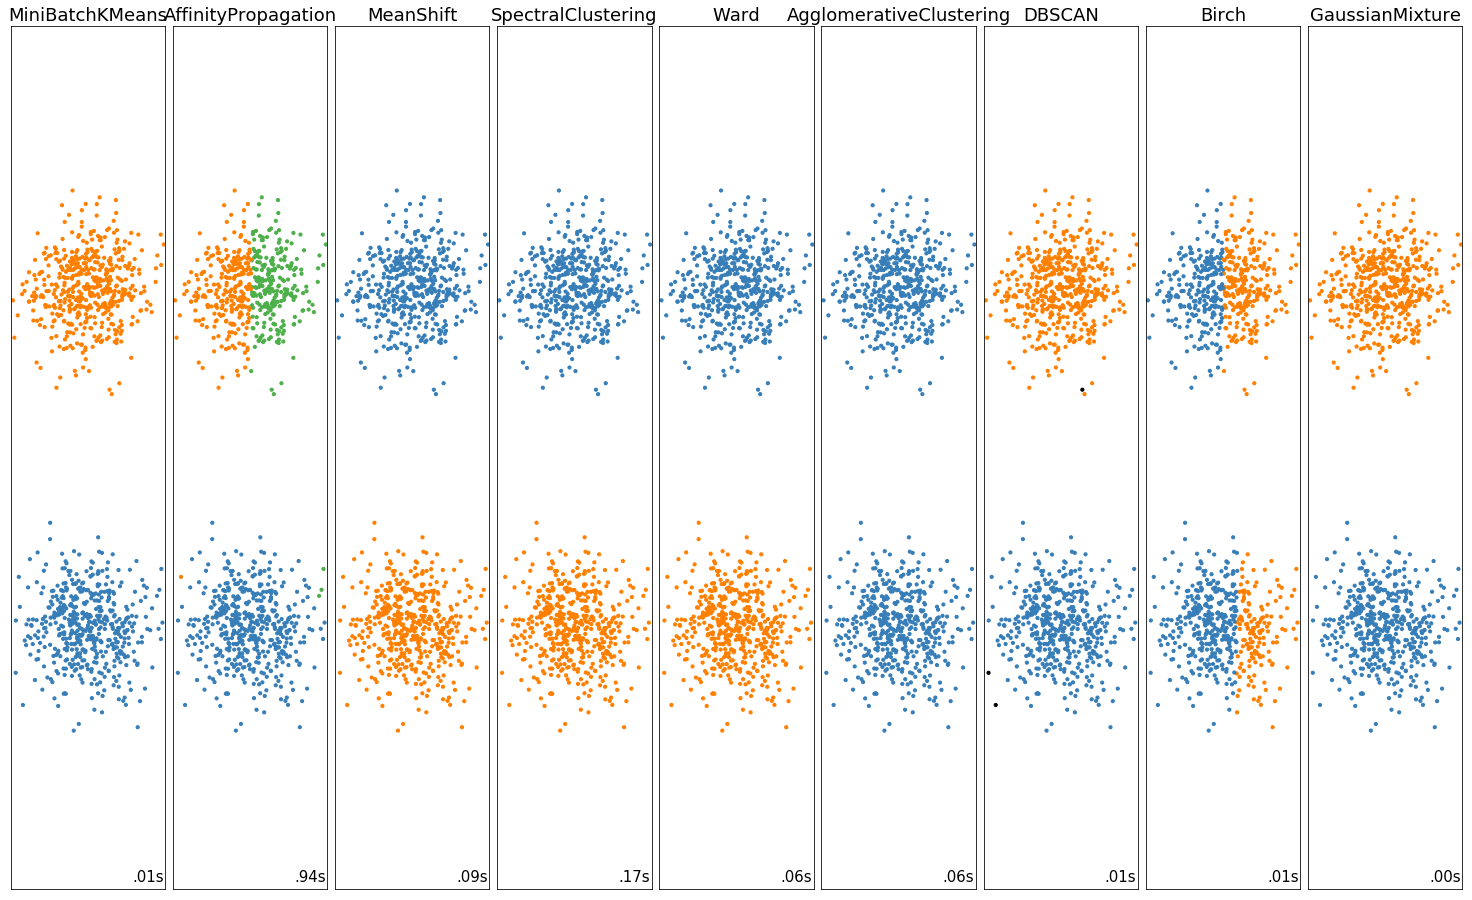

In [32]:
import time
import warnings

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice


plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

datasets = [
    (data_long, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
#     (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
#     (varied, {'eps': .18, 'n_neighbors': 2,
#               'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
#     (aniso, {'eps': .15, 'n_neighbors': 2,
#              'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
#     (blobs, {}),
#     (no_structure, {})
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X = data_long[:, :2]

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
#     optics = cluster.OPTICS(min_samples=params['min_samples'],
#                             xi=params['xi'],
#                             min_cluster_size=params['min_cluster_size'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        ('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        #('OPTICS', optics),
        ('Birch', birch),
        ('GaussianMixture', gmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

# Nb end

In [1]:
nb_end = dt.now()

'Time elapsed: %s' % (nb_end - nb_start)

NameError: name 'dt' is not defined

---

# Bibliography

---